In [1]:
import numpy as np
import pandas as pd

In [2]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased") 

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertM

In [3]:
from typing import Callable, List, Optional, Tuple
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch
from IPython.display import clear_output

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bert_tokenizer, bert_model, max_length):

        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()
        self.max_length = max_length
        self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        tokenized_text = self.bert_tokenizer.encode_plus(text,
                                                         add_special_tokens=True,
                                                         max_length=self.max_length
                                                         )["input_ids"]

        attention_mask = [1] * len(tokenized_text)

        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str, progress) -> torch.tensor:
        
        
        print(progress, flush=True)
        
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.bert_model(tokenized, attention_mask)
        
        clear_output(wait=True)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string, f'{text.index(string) + 1}/{len(text)}') for string in text])

    def fit(self, X, y=None):
        return self


In [131]:
X = 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5'
Y = 'GDT_score'
DATASET = 'GDT_NLP_FULLSTOPS.xlsx'
EVAL_DATASET = 'NLP_PILOT.xlsx'


In [132]:
df = pd.read_excel(io=DATASET)
eval_df = pd.read_excel(io=EVAL_DATASET)

print(len(df))
print(len(eval_df))

522
95


In [133]:
bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [134]:
import time
all_x = []

for item in X:

    if 'nlp' in item:
        item_processed = bert_transformer.transform(list(df[item]))
        all_x.append(item_processed)
        print(f'{item} added to list')
        time.sleep(0.5)

    elif item == 'sex':
        all_x.append(list(df[item]))
        print(f'{item} added to list')
        time.sleep(0.5)
    
    else:
        item_processed = [[item] for item in df[item]]
        
        all_x.append(item_processed)
        print(f'{item} added to list')
        time.sleep(0.5)

all_x = tuple(all_x)
X_train = np.hstack(all_x)

nlp_5 added to list


In [135]:
Y_train = df[Y]
X_train.shape

(522, 3072)

In [136]:
import time
all_x = []

for item in X:
    
    if 'nlp' in item:
        item_processed = bert_transformer.transform(list(eval_df[item]))
        all_x.append(item_processed)
        print(f'{item} added to list')
        time.sleep(0.5)

    elif item == 'sex':
        all_x.append(list(eval_df[item]))
        print(f'{item} added to list')
        time.sleep(0.5)
    
    else:
        item_processed = [[item] for item in eval_df[item]]
        
        all_x.append(item_processed)
        print(f'{item} added to list')
        time.sleep(0.5)

all_x = tuple(all_x)
X_test = np.hstack(all_x)

Y_test = eval_df[Y]
X_test.shape

nlp_5 added to list


(95, 3072)

In [294]:
from sklearn import svm

vector_regression = svm.SVR(kernel='linear', C=0.1, tol=1e-3)
vector_regression.fit(X_train, Y_train)


SVR(C=0.1, kernel='linear')

In [295]:
results = vector_regression.predict(X_test)

In [296]:
from scipy import stats
results = [item if item >= 4 else 4 for item in results]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, Y_test))

PearsonRResult(statistic=0.3126690147367843, pvalue=0.002036117809671508)


In [297]:
answers_tuples = [(y, res) for y, res in zip(Y_test, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(item) for item in result]

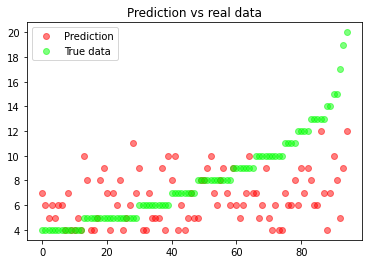

In [298]:
import matplotlib.pyplot as plt

plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.5], label="Prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.5], label='True data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data')
plt.show()